# LDA Demonstration


In this notebook, we will build LDA models on various datasets. We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [22]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
!pip install pyLDAvis
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Amazon Product Reviews Dataset - Echo/Alexa

For building topic models, let's experiment with the Amazon product reviews dataset. We have a list of reviews of a few amazon products such as Kindle, Echo (Alexa) etc. 

In [23]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [24]:
df = pd.read_csv('/gdrive/My Drive/Deep Learning AIML/Statistical NLP/Notebooks/New/LDA/7817_1.csv')

In [26]:
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-08-08T00:00:00.000Z,NaN,139.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-09-01T00:00:00.000Z,NaN,126.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-07-20T00:00:00.000Z,NaN,69.0,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2017-06-16T00:00:00.000Z,NaN,2.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2016-08-11T00:00:00.000Z,NaN,17.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


Let's now filter the dataframe to only one product - Amazon Echo. If you are not aware of Echo, <a href="https://www.amazon.in/Amazon-Echo-control-weather-Powered/dp/B0749YXL1J?tag=googinhydr18418-21">here's the amazon page</a>.

In [27]:
# filter for product id = amazon echo
df = df[df['asins']=="B01BH83OOM"]
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",NaN,NaN,806.0,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",2016-04-05T00:00:00.000Z,NaN,426.0,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",NaN,NaN,295.0,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",2016-05-31T00:00:00.000Z,True,0.0,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",2016-05-30T00:00:00.000Z,True,3.0,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


### Preprocessing

Let's first do some preprocessing. For tokenisation, though one can use NLTK as well, let's try using gensim's ```simple_preprocess``` this time. The preprocessing pipeline is mentioned below.<br>

1. Tokenize each review (using gensim)
2. Remove stop words (including punctuations)
3. Lemmatize (using spacy)

Though you can build topic models without lemmatisation, it is actually quite important (and highly recommended) because otherwise you may end up getting topics having similar words for e.g. *speaker, speakers* etc. (which are basically referring to the same thing - speaker).

Note that lemmatization uses POS tags of words, so we need to specify a list of POS tags - here we've used ```['NOUN', 'ADJ', 'VERB', 'ADV']``` .

In [28]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


The code below creates a list of stop words. The 'string' module in python comes with a list of punctuation characters, which we'll append to the builtin stopwords of NLTK.

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)


In [31]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

**Important Note:** All models are not automatically downloaded with spacy, so you will need to do a ```python -m spacy download en``` to use its preprocessing methods.

In [32]:
# call functions

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER 
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'speaker', 'first', 'echo', 'replacement', 'second', 'big', 'reason', 'buy', 'standard', 'bluetooth', 'speaker', 'wifi', 'stream', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'microphone', 'button', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [33]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker; 
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable speaker first echo replacement second big reason buy standard bluetooth speaker wifi stream enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap microphone button voice want big sound always listen feature spend extra money


### Creating Dictionary and Corpus

Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.

In [34]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(2, 1), (11, 1), (14, 2), (15, 3), (17, 1), (18, 2), (22, 4), (27, 1), (30, 1), (33, 1), (47, 1), (52, 1), (56, 5), (66, 1), (78, 1), (81, 3), (84, 1), (85, 2), (90, 1), (91, 1), (92, 2), (94, 1), (95, 1), (97, 1), (106, 2), (110, 1), (116, 1), (120, 1), (130, 2), (133, 1), (136, 1), (142, 1), (143, 1), (144, 2), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 2), (156, 1), (157, 2), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 3), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 2), (184, 1), (185, 5), (186, 1), (187, 3), (188, 2), (189, 1), (190, 3), (191, 1), (192, 1), (193, 1), (194, 1), (195, 6), (196, 1), (197, 1), (198, 2), (199, 1), (200, 2), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 2), (207, 1), (208, 2), (209, 1)]


The (3, 7) above represents the fact that the word with id=3 appears 7 times in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.

In [35]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('allow', 1),
  ('amazon', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 2),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('aware', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('could', 2),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 6),
  ('echos', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode', 2),
  ('music', 2),
  ('new', 1),
  ('operation', 1),
  ('option',

### Building the Topic Model

Let's now build the topic model. We'll define 10 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic
(theta) distributions, whose default value is 1. Similarly, the hyperparameter `eta` can also be specified, which affects the topic-word distribution's sparsity.



In [36]:
# help(gensim.models.ldamodel.LdaModel)

In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Let's now print the topics found in the dataset.

In [38]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"great" + 0.047*"echo" + 0.047*"sound" + 0.043*"tap" + 0.039*"use" + '
  '0.034*"love" + 0.032*"good" + 0.031*"speaker" + 0.025*"alexa" + '
  '0.024*"buy"'),
 (1,
  '0.084*"get" + 0.047*"tap" + 0.037*"purchase" + 0.029*"want" + 0.026*"fun" + '
  '0.021*"lot" + 0.021*"wish" + 0.020*"weather" + 0.020*"item" + 0.019*"even"'),
 (2,
  '0.053*"gift" + 0.028*"must" + 0.025*"mostly" + 0.022*"super" + 0.021*"live" '
  '+ 0.018*"technology" + 0.016*"movie" + 0.015*"area" + 0.015*"invest" + '
  '0.014*"tub"'),
 (3,
  '0.048*"size" + 0.031*"move" + 0.021*"pretty" + 0.020*"favorite" + '
  '0.020*"bass" + 0.019*"amazon" + 0.018*"system" + 0.016*"hook" + '
  '0.016*"functionality" + 0.015*"room"'),
 (4,
  '0.051*"phone" + 0.032*"use" + 0.031*"music" + 0.029*"speaker" + '
  '0.027*"bluetooth" + 0.024*"stream" + 0.018*"play" + 0.017*"control" + '
  '0.017*"amazing" + 0.017*"access"'),
 (5,
  '0.044*"wifi" + 0.040*"free" + 0.032*"try" + 0.029*"long" + 0.026*"hand" + '
  '0.026*"touch" + 0.

Let's now evaluate the model using coherence score.

In [39]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4350983815596237


Now lets visualise the topics. The `pyLDAvis` library comes with excellent interactive visualisation capabilities.

In [40]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.378720  0.072575       1        1  47.791919
1     -0.111957 -0.295903       2        1  11.600061
4     -0.095052  0.093667       3        1   8.026991
7      0.058474  0.030566       4        1   6.027072
6      0.044471  0.143279       5        1   5.825040
5      0.072490 -0.019010       6        1   5.362704
9      0.095858  0.017890       7        1   4.442575
3      0.085391  0.010458       8        1   4.201646
8      0.114591 -0.019798       9        1   3.774747
2      0.114453 -0.033723      10        1   2.947245, topic_info=       Term        Freq       Total Category  logprob  loglift
35      get   84.000000   84.000000  Default  30.0000  30.0000
91      use  184.000000  184.000000  Default  29.0000  29.0000
81      tap  229.000000  229.000000  Default  28.0000  28.0000
168   great  221.000000  221.000000  Default  27.0000  27.0000
78    sound  197.000000  197.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
778    form    1.672578    2.413845  Topic10  -5.0229   3.1574
804   movie    4.179339    6.136071  Topic10  -4.1072   3.1403
163  expect    3.547803    5.574128  Topic10  -4.2710   3.0725
340    gift   13.531308   25.819524  Topic10  -2.9323   2.8782
88    touch    2.542128   15.008193  Topic10  -4.6043   1.7487

[444 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
98        7  0.523095     ability
98        8  0.418476     ability
276       1  0.984241        able
417      10  0.757069  absolutely
229       3  0.884262      access
...     ...       ...         ...
97        1  0.839449       would
97        5  0.148935       would
142       2  0.747651        year
142       7  0.106807        year
677       7  0.885960         yet

[517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 8, 7, 6, 10, 4, 9, 3])

## Hyperparameter Tuning - Number of Topics and Alpha

Let's now tune the two main hyperparameters - number of topics and alpha. The strategy typically used is to tune these parameters such that the coherence score is maximised.

In [ ]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [ ]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [ ]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.465229
1,0.01,6,0.454546
2,0.01,10,0.406792
3,0.01,15,0.431168
4,0.01,20,0.402189
5,0.10,2,0.459691
6,0.10,6,0.419994
7,0.10,10,0.438603
8,0.10,15,0.435700
9,0.10,20,0.439248


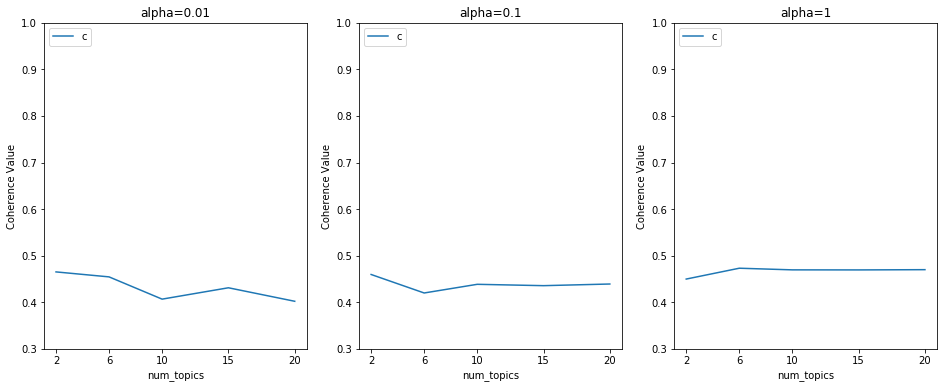

In [ ]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

### Demonetisation Tweets

Let's now try identifying topics in tweets related to a specific topic - demonetisation. The overall pipeline is the same, apart from someextra preprocessing steps.

In [ ]:
df = pd.read_csv("demonetization-tweets.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(14940, 16)


,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [ ]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'RT @centerofright: #DeMonetization - Ppl are ready to give @narendramodi the 50 Days he asked for in the war against corruption and black m\x85'

In [ ]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have strings such as RT, @xyz, etc. Some have URLs, punctuation marks, smileys etc. The following code cleans the data to handle many of these issues.

In [ ]:
# remove URLs
def remove_URL(x):
            return x.replace(r'https[a-zA-Z0-9]*', "", regex = True)


# clean tweet text
def clean_tweets(tweet_col):
    
    df = pd.DataFrame({'tweet':tweet_col})
    
    df['tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet'] = df['tweet'].replace("  ", " ")
    df['tweet'] = df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet'] = remove_URL(df['tweet'])
    df['tweet'] = df['tweet'].str.lower() 
    
    return(df)

cleaned_tweets = clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: indias #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


Since tweets often contain slang words such as *wat, rt, lol* etc, we can append the stopwords with a list of such custom words and remove them.

In [ ]:
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']


# remove stop words, punctuations 
stop_words = set(list(stopwords.words('english') + 
                      list(string.punctuation) +
                      words_remove)) 

data_words = list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))


# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# sample lemmatized tweets
data_lemmatized[:3]

[['critical',
  'question',
  'paytm',
  'inform',
  'demonetization',
  'edict',
  'pm',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 ['vote', 'demonetization', 'modi', 'survey', 'app'],
 ['former',
  'finsec',
  'rbi',
  'governor',
  'cbdt',
  'chair',
  'harvard',
  'professor',
  'lambaste',
  'demonetization',
  'aadmi',
  'listen']]

In [ ]:
# create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

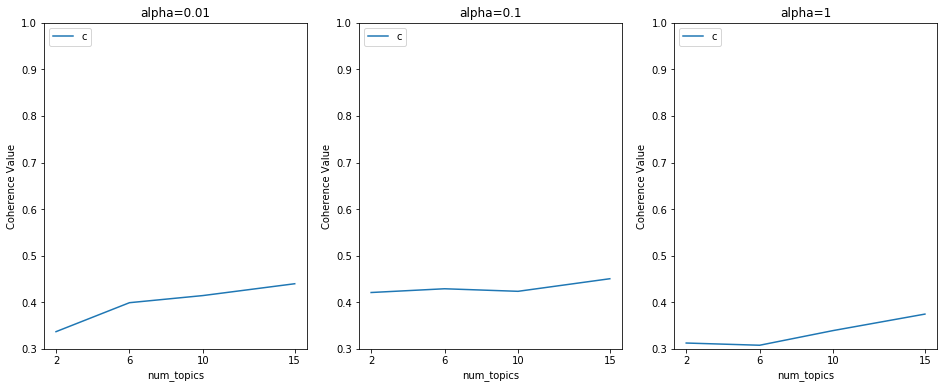

In [ ]:
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [ ]:
# Build LDA model with alpha=0.1 and 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=True)

In [ ]:
# print keywords 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"modi" + 0.088*"demonetization" + 0.066*"poor" + 0.062*"love" + '
  '0.062*"quiet" + 0.061*"men" + 0.061*"prohibition" + 0.061*"tobaccogutkha" + '
  '0.061*"engli" + 0.050*"implement"'),
 (1,
  '0.084*"demonetization" + 0.062*"youtube" + 0.059*"people" + 0.049*"economy" '
  '+ 0.027*"indian" + 0.026*"flag" + 0.026*"reinstate" + 0.025*"thus" + '
  '0.025*"ge" + 0.018*"back"'),
 (2,
  '0.185*"ed" + 0.081*"demonetization" + 0.063*"keep" + 0.038*"bc" + '
  '0.036*"bf" + 0.036*"headline" + 0.036*"yearend" + 0.033*"wave" + '
  '0.028*"index" + 0.028*"ad"'),
 (3,
  '0.112*"ban" + 0.091*"find" + 0.081*"demonetization" + 0.057*"economic" + '
  '0.045*"effect" + 0.043*"tcoe" + 0.028*"less" + 0.027*"system" + '
  '0.025*"double" + 0.024*"already"'),
 (4,
  '0.085*"demonetization" + 0.077*"pm" + 0.052*"due" + 0.050*"shortage" + '
  '0.048*"ufe" + 0.038*"question" + 0.036*"end" + 0.034*"parliament" + '
  '0.033*"coast" + 0.033*"fisherman"'),
 (5,
  '0.077*"cash" + 0.059*"demonetizatio

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4645754680906517


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      14.642657        1       1 -0.053408 -0.009416
7      13.439916        1       2  0.066220  0.004847
5      10.127769        1       3 -0.125509 -0.003342
6       9.871559        1       4 -0.117661  0.016894
0       9.829674        1       5  0.271932 -0.273334
1       9.506565        1       6 -0.090176 -0.014362
2       9.334724        1       7  0.228325  0.315480
9       8.173551        1       8 -0.071373 -0.005770
3       7.688958        1       9 -0.026028 -0.021636
8       7.384621        1      10 -0.082322 -0.009360, topic_info=     Category         Freq            Term         Total  loglift  logprob
term                                                                      
97    Default  2581.000000              ed   2581.000000  30.0000  30.0000
47    Default  2813.000000           india   2813.000000  29.0000  29.0000
593   Default  1397.000000            rich   1397.000000  28.0000  28.0000
14    Default  1437.000000            modi   1437.000000  27.0000  27.0000
214   Default  1286.000000             ban   1286.000000  26.0000  26.0000
10    Default  1678.000000              pm   1678.000000  25.0000  25.0000
123   Default  1179.000000            good   1179.000000  24.0000  24.0000
1146  Default  1049.000000            find   1049.000000  23.0000  23.0000
28    Default  1158.000000            cash   1158.000000  22.0000  22.0000
947   Default  1323.000000            will   1323.000000  21.0000  21.0000
2212  Default  1496.000000         youtube   1496.000000  20.0000  20.0000
206   Default   908.000000          result    908.000000  19.0000  19.0000
170   Default   961.000000            poor    961.000000  18.0000  18.0000
356   Default  1145.000000             due   1145.000000  17.0000  17.0000
1129  Default  1061.000000            dear   1061.000000  16.0000  16.0000
57    Default   915.000000               s    915.000000  15.0000  15.0000
2241  Default   911.000000            love    911.000000  14.0000  14.0000
2616  Default   902.000000           quiet    902.000000  13.0000  13.0000
907   Default   881.000000            keep    881.000000  12.0000  12.0000
330   Default  1089.000000        shortage   1089.000000  11.0000  11.0000
9475  Default   902.000000   tobaccogutkha    902.000000  10.0000  10.0000
9474  Default   902.000000     prohibition    902.000000   9.0000   9.0000
9473  Default   902.000000             men    902.000000   8.0000   8.0000
9472  Default   902.000000           engli    902.000000   7.0000   7.0000
604   Default   864.000000           staff    864.000000   6.0000   6.0000
6839  Default  1041.000000             ufe   1041.000000   5.0000   5.0000
2156  Default   995.000000        actually    995.000000   4.0000   4.0000
89    Default   837.000000          people    837.000000   3.0000   3.0000
6929  Default   843.000000            yogi    843.000000   2.0000   2.0000
8678  Default   833.000000      adityanath    833.000000   1.0000   1.0000
...       ...          ...             ...           ...      ...      ...
327   Topic10   265.359924             day    266.236145   2.6025  -3.7251
7896  Topic10   133.650345       diwasyoga    134.530945   2.5992  -4.4110
7897  Topic10   133.650345       drivesgau    134.530945   2.5992  -4.4110
7898  Topic10   133.650345     rakshaksetc    134.530945   2.5992  -4.4110
7899  Topic10   133.650345           stunt    134.530945   2.5992  -4.4110
7900  Topic10   133.650345        swachata    134.530945   2.5992  -4.4110
27    Topic10   119.601585             rbi    120.477890   2.5985  -4.5221
1832  Topic10    89.840126          update     90.716438   2.5961  -4.8082
663   Topic10    90.031380        surgical     90.914536   2.5960  -4.8061
9387  Topic10   505.797363      politicsit    511.246979   2.5951  -3.0801
9388  Topic10   505.797363     transparent    511.246979   2.5951  -3.0801
193   Top

### BBC News Dataset

In [ ]:
# reading the BBC news dataset

data_folder = "./bbc"

folders = ["business","entertainment","politics","sport","tech"]

x = []
y = []

for i in folders:
    files = os.listdir(data_folder + "/" + i)
    for text_file in files:
        file_path =  data_folder + "/" + i + "/" + text_file
        with open(file_path, 'rb') as f:
            data = f.read()
#         data = ' '.join(data)
        x.append(data)
        y.append(i)


data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.to_csv('bbc_data.csv', index=False)

In [ ]:
df.head()

,news,type
0,b'Ad sales boost Time Warner profit\n\nQuarter...,business
1,b'Dollar gains on Greenspan speech\n\nThe doll...,business
2,b'Yukos unit buyer faces loan claim\n\nThe own...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,"b""Pernod takeover talk lifts Domecq\n\nShares ...",business


In [ ]:
df.type.astype('category').value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

In [ ]:
# filter business articles
df = df[df['type']=='business']
df.shape

(510, 2)

In [ ]:
# convert to list
data = df['news'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4798648900050903


In [ ]:
# print keywords 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.103*"china" + 0.058*"tariff" + 0.046*"trade" + 0.028*"country" + '
  '0.019*"world" + 0.016*"aid" + 0.014*"organisation" + 0.013*"peace" + '
  '0.011*"membership" + 0.011*"wto"'),
 (1,
  '0.030*"india" + 0.025*"car" + 0.025*"sale" + 0.021*"rupee" + '
  '0.019*"vehicle" + 0.018*"utility" + 0.016*"maruti" + 0.015*"company" + '
  '0.014*"drug" + 0.014*"club"'),
 (2,
  '0.036*"bank" + 0.017*"rate" + 0.017*"figure" + 0.016*"year" + 0.016*"rise" '
  '+ 0.015*"market" + 0.013*"month" + 0.012*"december" + 0.011*"fall" + '
  '0.011*"quarter"'),
 (3,
  '0.050*"water" + 0.026*"government" + 0.023*"region" + 0.020*"economic" + '
  '0.014*"country" + 0.014*"area" + 0.013*"report" + 0.011*"close" + '
  '0.011*"fuel" + 0.010*"resort"'),
 (4,
  '0.024*"firm" + 0.024*"lse" + 0.021*"boerse" + 0.020*"lvmh" + '
  '0.018*"exchange" + 0.016*"london" + 0.016*"bid" + 0.016*"stock" + '
  '0.012*"offer" + 0.012*"share"'),
 (5,
  '0.027*"yukos" + 0.017*"deutsche" + 0.015*"oil" + 0.015*"russian" + '
  '

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     27.484671        1       1 -0.231200 -0.107745
14     13.856689        1       2 -0.259025  0.110482
15     11.671943        1       3 -0.248496  0.190147
2       7.870289        1       4 -0.241532  0.168697
5       6.564722        1       5 -0.079503 -0.181212
8       6.226865        1       6 -0.114575 -0.217095
1       5.107977        1       7 -0.092067 -0.058520
4       2.977449        1       8  0.007600 -0.147594
3       2.727693        1       9  0.024663  0.106529
18      2.056834        1      10  0.159470  0.052544
9       2.056663        1      11  0.127093  0.055089
10      1.748156        1      12 -0.036210 -0.095372
0       1.662864        1      13  0.116549  0.096463
11      1.504212        1      14  0.062780 -0.076907
12      1.466877        1      15  0.121710  0.013027
7       1.359322        1      16  0.090388 -0.066379
19      1.130519        1      17  0.163165  0.042665
13      0.995548        1      18  0.089712  0.022666
17      0.786104        1      19  0.169897  0.036485
6       0.744602        1      20  0.169582  0.056029, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
174   Default  262.000000          china  262.000000  30.0000  30.0000
470   Default  313.000000          world  313.000000  29.0000  29.0000
273   Default  248.000000          trade  248.000000  28.0000  28.0000
28    Default  702.000000        company  702.000000  27.0000  27.0000
674   Default  293.000000        country  293.000000  26.0000  26.0000
55    Default  505.000000           firm  505.000000  25.0000  25.0000
167   Default  358.000000           bank  358.000000  24.0000  24.0000
461   Default  306.000000          state  306.000000  23.0000  23.0000
204   Default  296.000000     government  296.000000  22.0000  22.0000
317   Default  219.000000          group  219.000000  21.0000  21.0000
114   Default  280.000000         profit  280.000000  20.0000  20.0000
130   Default  393.000000           sale  393.000000  19.0000  19.0000
159   Default  883.000000           year  883.000000  18.0000  18.0000
559   Default  283.000000       economic  283.000000  17.0000  17.0000
227   Default  334.000000           make  334.000000  16.0000  16.0000
120   Default  306.000000         report  306.000000  15.0000  15.0000
248   Default  383.000000          price  383.000000  14.0000  14.0000
48    Default  268.000000      executive  268.000000  13.0000  13.0000
129   Default  421.000000           rise  421.000000  12.0000  12.0000
72    Default  269.000000           high  269.000000  11.0000  11.0000
1978  Default  126.000000          water  126.000000  10.0000  10.0000
1045  Default  211.000000           plan  211.000000   9.0000   9.0000
338   Default  236.000000            oil  236.000000   8.0000   8.0000
373   Default  161.000000          yukos  161.000000   7.0000   7.0000
690   Default  139.000000          india  139.000000   6.0000   6.0000
172   Default  161.000000            buy  161.000000   5.0000   5.0000
70    Default  348.000000         growth  348.000000   4.0000   4.0000
561   Default  317.000000        economy  317.000000   3.0000   3.0000
3211  Default   97.000000      argentina   97.000000   2.0000   2.0000
699   Default  195.000000             mr  195.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
8627  Topic20    9.098295         alegre    9.893636   4.8163  -4.3108
8628  Topic20    8.548270     appearance    9.343611   4.8111  -4.3731
8644  Topic20    7.998246           mute    8.793586   4.8053  -4.4396
8661  Topic20    7.998246        warming    8.793586   4.8053  -4.4396
8643  Topic20    7.998246          mbeki    8.793586   4.8053  -4.4396
8658  Topic20    7.998246          thabo    8.793586   4.8053  -4.4396


## Amazon Cell Phones and Accessories Reviews (Ignore)


In [ ]:
# all electronic products
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')

In [ ]:
df.shape

(194439, 9)

In [ ]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3.0,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5.0,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1.0,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5.0,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,1396483200,"04 3, 2014"


In [ ]:
# convert to list
data = df['reviewText'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

KeyboardInterrupt: 

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)